# Starspot-Model

A computer model capable of generating photometric light curves of a rotating spotted star with a transiting exoplanet.

The code below sets up a simulation of a solar-like star with an orbting hot Jupiter. It rus the simulation and then performs various analyses on the outputs.

Use this notebook as a guide on how to setup and use the model.

### Manage imports

In [1]:
# Python libraries
import time
import numpy as np

# Model classes
import settings
from params import Params
from star import Star
from planet import Planet
from spot import Spot
from system import System

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Utils
import utils # tissot function for spot map
import occultquad # Eastman python implementation of Mandel & Agol (2002)
import peakdetect # Peak finding algorithm

## Setup system parameters

In [2]:
# Initialise global variables
settings.init()

# Set up parameters
params = Params()
# Star params
# Coefficients used from Claret (2000) in visible spectrum (V)
# For a star similar to Sun (Teff = 5750, logg = 4.5, Metalicity = 0)
params.prot = 24
params.rad_star = 1
params.sinc = 30
params.res = 300
params.u = [0.4442, 0.2861]
params.high_band = [30, 45]
params.low_band = [0, 15]
params.stellar_cycle = 365#4015 # 11 years in days

# Planet params
params.rp = 0.1
params.per = 12
params.w = 90
params.a = 15
params.t0 = 3 # Transit after x days of simulation
params.oinc = 90 # 90 = No impact param
params.beta = 45 # 90 = Horizontal (Normal), 0 = Vertical

# Spot params
params.b = [0.1, 0.4]
params.spot_rads = [0.03, 0.11]
params.spot_lives = [80, 100]
params.spot_asymmetry = 0.5
params.nspots = 5

# System params
params.rotation_dt = 0.2
params.transit_dt = 0.002
params.adjustDistance = 1.5

# Star
star = Star(params)

# Spots
spots = [Spot.gen_spot(params, star, 0) for i in range(0, params.nspots)]
star.addSpots(spots)

# Planet
planet = Planet(params)

# System params: star, planet, params
system = System(star, planet, params)

### Plot initial state

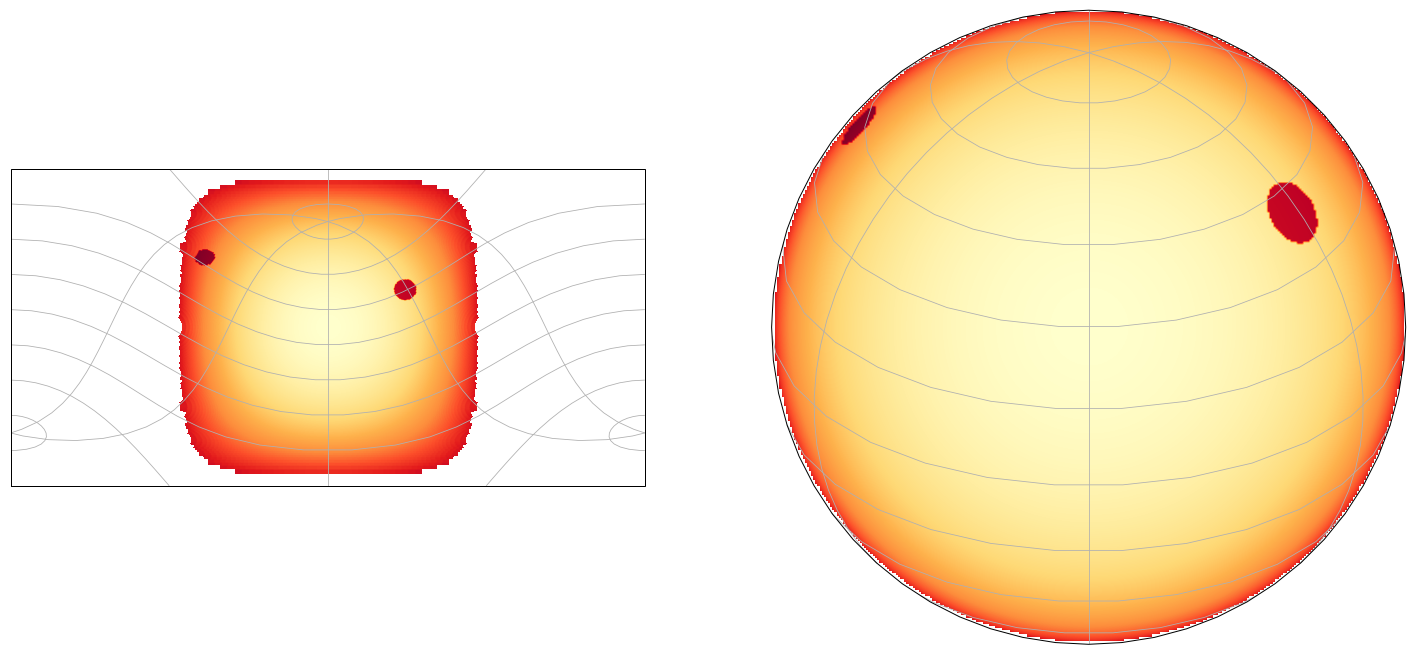

In [3]:
fig, axes = plt.subplots(1,2,figsize=(25,25))

cmap = plt.cm.YlOrRd_r
cmap.set_bad('w')

# Rotated projection
axes[0] = plt.subplot(121, projection=star.rotated_proj)
axes[0].gridlines()
axes[0].set_global()

# Globe projection
axes[1] = plt.subplot(122, projection=star.orth_proj)
axes[1].gridlines()
axes[1].set_global()

# Draw newly calculated contours
axes[0].imshow(star.spottedFlux, cmap=cmap, transform=star.orth_proj, interpolation='bilinear')
axes[1].imshow(star.spottedFlux, cmap=cmap, transform=star.orth_proj, interpolation='bilinear', extent=[-1,1,-1,1])

plt.show()

## Run simulations

In [4]:
dur =  5*365 # days

# With spots
start = time.time()
I, D, Time, TTimes, SAR = system.simulate(dur, False, 10)
end = time.time()
print('Took {0} seconds for spotted light curve generation'.format(end-start))

# With no spots
system.star = Star(params)
start = time.time()
I_none, D_none, _,_,_ = system.simulate(dur, False, 10)
end = time.time()
print('Took {0} seconds for spotless light curve generation'.format(end-start))

Simulation 0% complete
Simulation 10% complete
Simulation 20% complete
Simulation 30% complete
Simulation 40% complete
Simulation 50% complete
Simulation 60% complete
Simulation 70% complete
Simulation 80% complete
Simulation 90% complete
Took 5265.247447967529 seconds for spotted light curve generation
Simulation 0% complete
Simulation 10% complete
Simulation 20% complete
Simulation 30% complete
Simulation 40% complete
Simulation 50% complete
Simulation 60% complete
Simulation 70% complete
Simulation 80% complete
Simulation 90% complete
Took 1633.6928119659424 seconds for spotless light curve generation


## Plot Light Curves

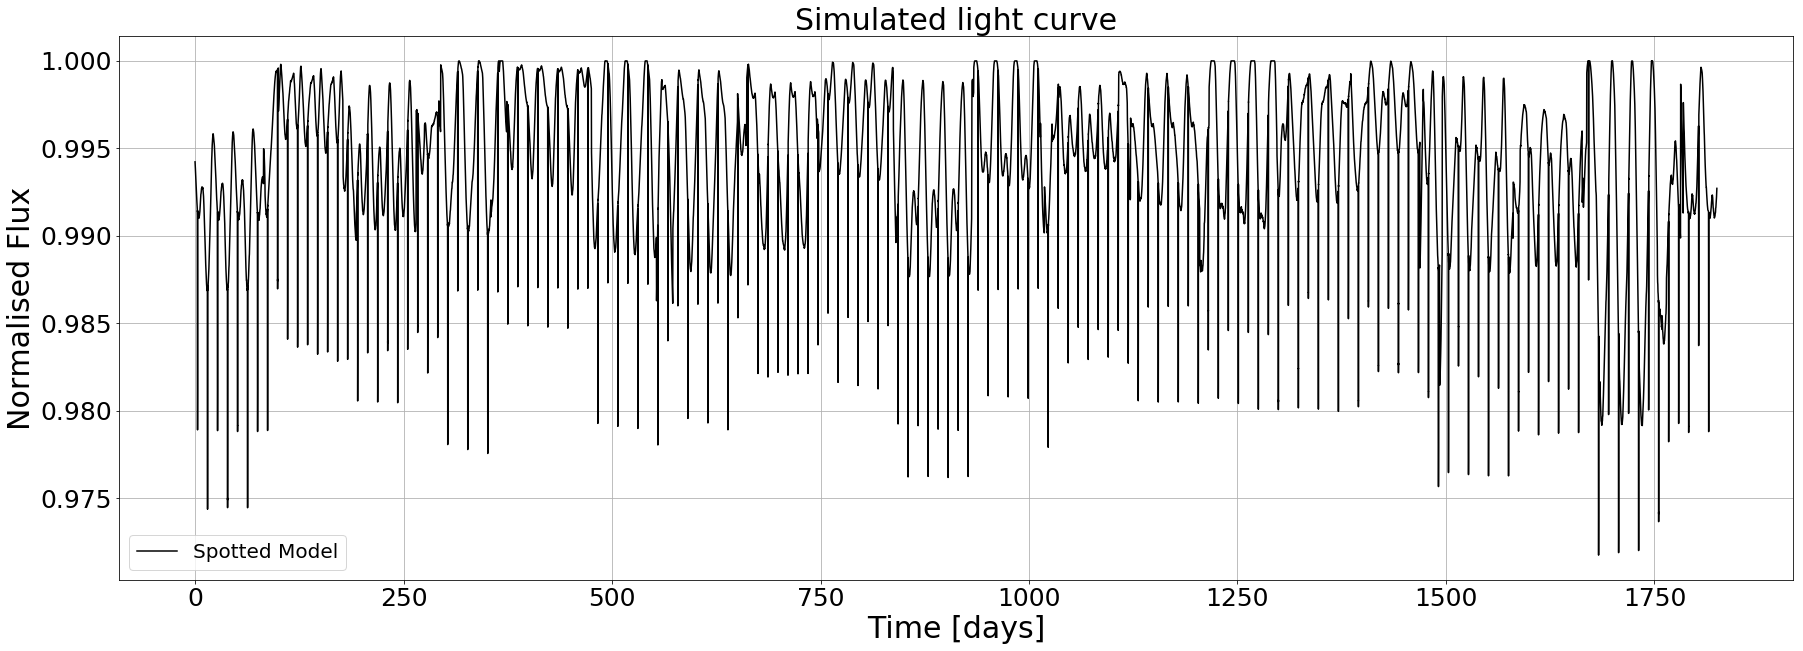

In [64]:
plt.figure(figsize=(30,10))
plt.plot(Time, I, 'k', label='Spotted Model')
#plt.plot(Time, I_none, 'b', label='Spotted Model')
plt.ylabel('Normalised Flux', fontsize= 30)
plt.xlabel('Time [days]', fontsize=30)
plt.title(r'Simulated light curve', fontsize=30)
plt.grid()
plt.legend(fontsize=20)
#plt.xlim([TTimes[0][0]-1, TTimes[0][1]+1])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()

### Plot Phase Folded Light Curve

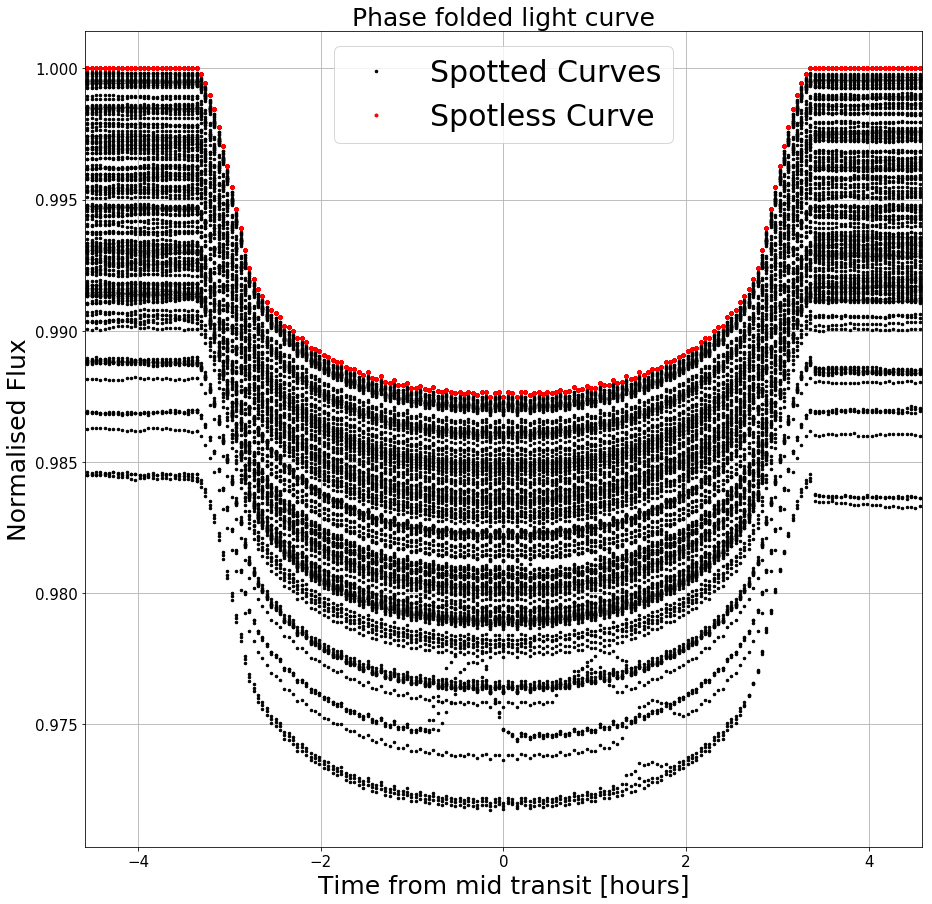

In [6]:
foldPhases = (np.asarray(Time) - params.t0) / params.per
foldPhases = foldPhases - np.round(foldPhases)
foldTimes = foldPhases*params.per*24
traWidth = (TTimes[0][1] - TTimes[0][0] + 0.1)*24
plt.figure(figsize = (15,15))
plt.plot(foldTimes, I, 'k.', ms=5, label='Spotted Curves')
plt.plot(foldTimes, I_none, 'r.', label='Spotless Curve')
plt.ylabel('Normalised Flux', fontsize= 25)
plt.xlabel('Time from mid transit [hours]', fontsize=25)
plt.title(r'Phase folded light curve', fontsize=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=30, loc='upper center')
plt.xlim([-traWidth/2, traWidth/2])
plt.grid()
plt.show()

### Compare to Mandel & Agol (2002)

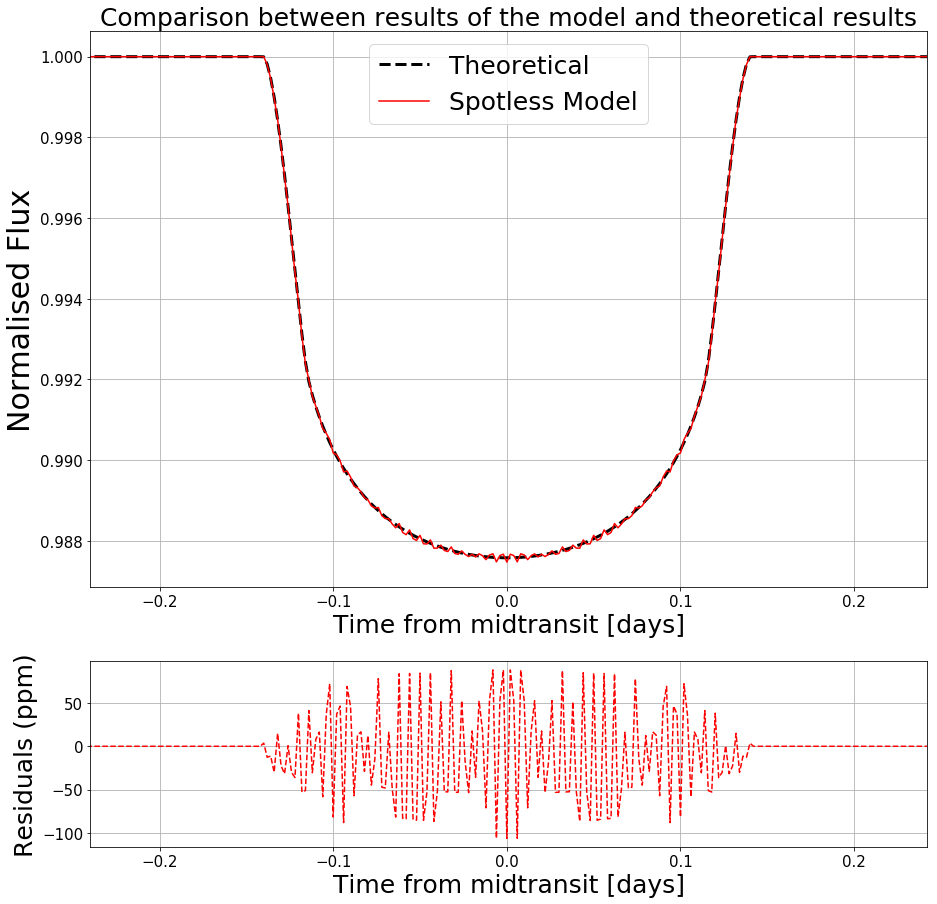

In [7]:
z = np.asarray([planet.r_skyAtTime(t) for t in Time])
ans = occultquad.occultquad(z,params.u[0],params.u[1],params.rp)
I_MA = ans[0]
transitNumber = 0
correctedTimes = np.asarray(Time) - params.t0
correctedTTimes = np.asarray(TTimes) - params.t0

fig, axes = plt.subplots(2,1, figsize = (15,15), gridspec_kw = {'height_ratios':[3, 1]})
axes[0].plot(correctedTimes, I_MA, 'k--', lw=3, label='Theoretical')
axes[0].plot(correctedTimes, I_none, 'r', label='Spotless Model')
axes[0].set_title('Comparison between results of the model and theoretical results', fontsize=25)
axes[0].set_ylabel('Normalised Flux', fontsize= 30)
axes[0].set_xlabel('Time from midtransit [days]', fontsize=25)
axes[0].legend(fontsize=25)
axes[0].tick_params(labelsize=15)
axes[0].grid()
axes[0].set_xlim([correctedTTimes[transitNumber][0]-0.1, correctedTTimes[transitNumber][1]+0.1])

ppm = 1e-6
axes[1].plot(correctedTimes, (np.asarray(I_none) - I_MA)/ppm, 'r--')
axes[1].set_xlabel('Time from midtransit [days]', fontsize=25)
axes[1].set_ylabel('Residuals (ppm)', fontsize = 25)
axes[1].set_xlim([correctedTTimes[transitNumber][0]-0.1, correctedTTimes[transitNumber][1]+0.1])
axes[1].grid()
axes[1].tick_params(labelsize=15)
plt.show()

### Re-plot with assumed 100ppm noise

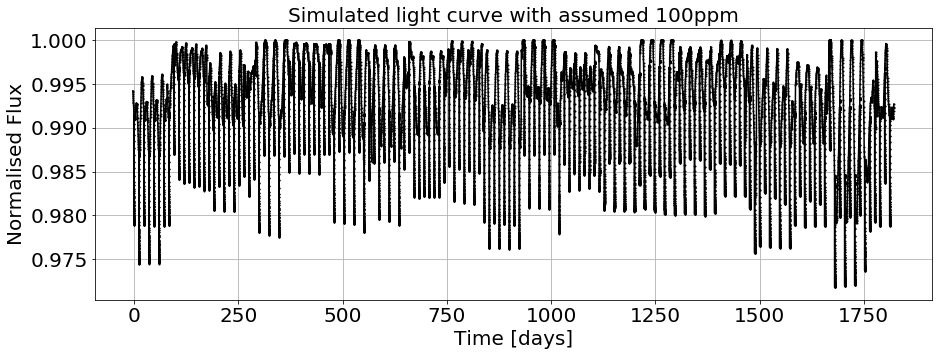

In [63]:
noiseLevel = 100*ppm
noise = np.random.normal(1,noiseLevel,len(I))
I_noise = noise*np.asarray(I)
D_noise = noise*np.asarray(D)

transitNumber = 0
plt.figure(figsize=(15,5))
plt.plot(np.asarray(Time) - params.t0, I, 'k', label='Spotted Model')
plt.plot(np.asarray(Time) - params.t0, I, 'k.', ms=2, label='Spotted Model + 150ppm Noise')
plt.ylabel('Normalised Flux', fontsize=20)
plt.xlabel('Time [days]', fontsize=20)
plt.title(r'Simulated light curve with assumed {0:.0f}ppm'.format(noiseLevel/ppm), fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.xlim([TTimes[transitNumber][0]-params.t0-1, TTimes[transitNumber][1]-params.t0+1])
plt.grid()
plt.show()

### Spot correction and residuals

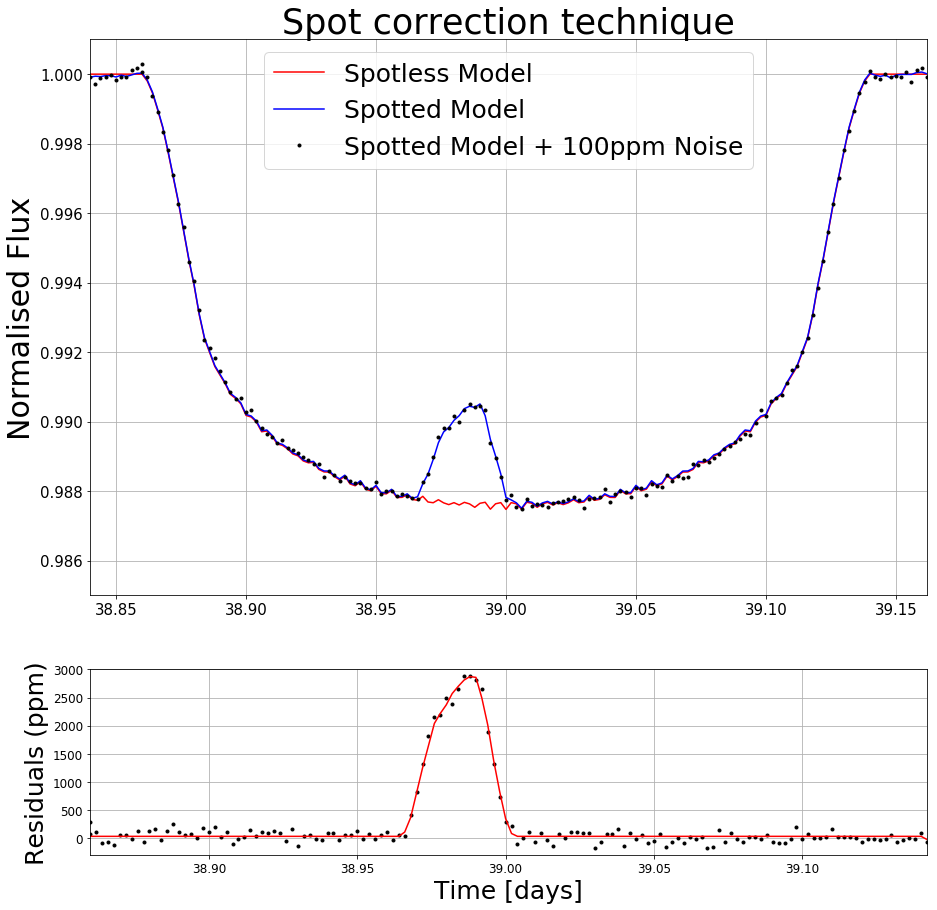

In [21]:
transitNumber = 3
idx1 = np.where(Time == np.asarray(TTimes)[transitNumber][0])[0][0]
idx2 = np.where(Time == np.asarray(TTimes)[transitNumber][1])[0][0]
offset1 = 1-I[idx1]
offset2 = 1-I[idx2]
offset = np.abs(offset1 + offset2)/2
I_corrected = np.asarray(I) + offset
I_corrected_noise = np.asarray(I_noise) + offset

fig, axes = plt.subplots(2,1, figsize = (15,15), gridspec_kw = {'height_ratios':[3, 1]})
axes[0].plot(Time, I_none, 'r', label='Spotless Model')
axes[0].plot(Time, I_corrected, 'b', label='Spotted Model')
axes[0].plot(Time, I_corrected_noise, 'k.', label='Spotted Model + {0:.0f}ppm Noise'.format(noiseLevel/ppm))
axes[0].set_title('Spot correction technique', fontsize=35)
axes[0].set_ylabel('Normalised Flux', fontsize= 30)
#axes[0].set_xlabel('Time [days]', fontsize=25)
axes[0].legend(fontsize=25, loc='upper center')
axes[0].tick_params(labelsize=15)
axes[0].grid()
axes[0].set_xlim([TTimes[transitNumber][0]-0.02, TTimes[transitNumber][1]+0.02])
axes[0].set_ylim([0.985, 1.001])

axes[1].plot(Time, (I_corrected_noise - np.asarray(I_none))/ppm, 'k.')
axes[1].plot(Time, (I_corrected - np.asarray(I_none))/ppm, 'r')
axes[1].set_xlabel('Time [days]', fontsize=25)
axes[1].set_ylabel('Residuals (ppm)', fontsize = 25)
axes[1].set_xlim(TTimes[transitNumber])
axes[1].set_ylim([-300,3000])
axes[1].grid()
axes[1].tick_params(labelsize=12)
plt.show()

### Re-plot phase folded light curve with spot corrected residuals

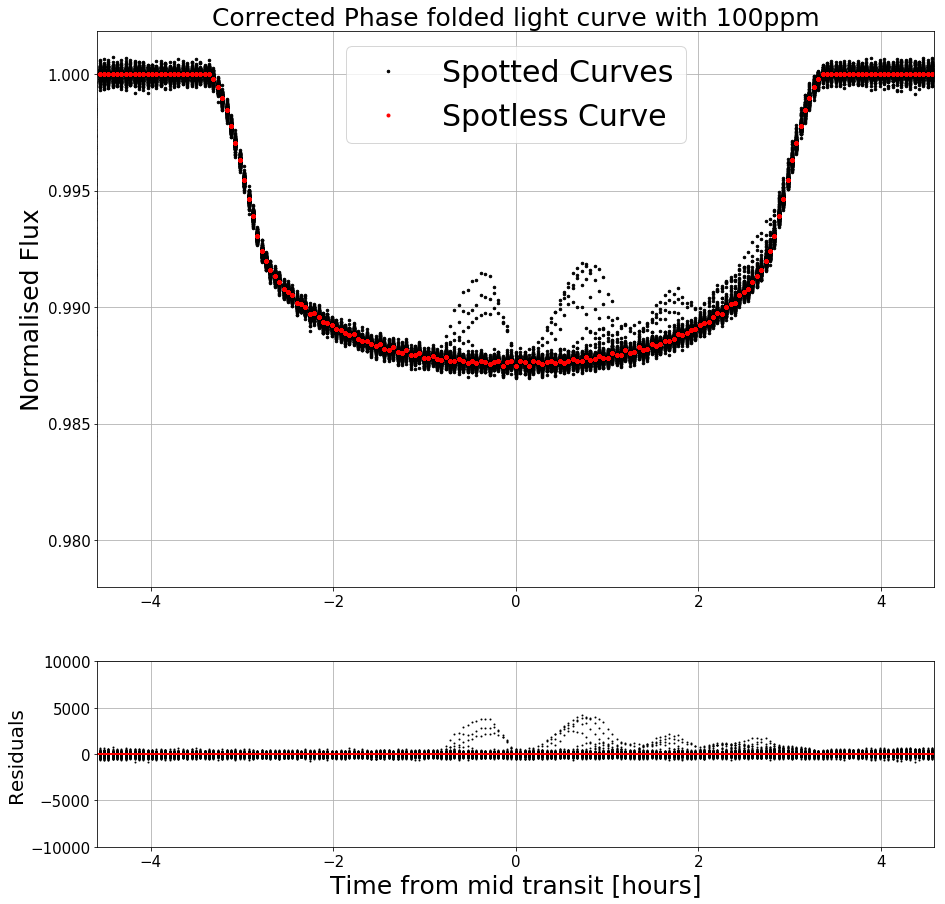

In [10]:
I_corrected_noise = np.asarray(I_noise)
I_res_noise = (I_noise - np.asarray(I_none))/ppm
shift = (int)(0.05/params.transit_dt)
for tNum in range(len(TTimes)):
        idx1 = np.where(Time == (np.asarray(TTimes)[tNum][0]))[0][0]
        idx2 = np.where(Time == (np.asarray(TTimes)[tNum][1]))[0][0]
        offset1 = 1-I[idx1]
        offset2 = 1-I[idx2]
        offset = np.abs(offset1 + offset2)/2
        I_corrected_noise[idx1-shift:idx2+shift] = np.asarray(I_noise[idx1-shift:idx2+shift]) + offset
        I_res_noise[idx1-shift:idx2+shift] = (I_corrected_noise[idx1-shift:idx2+shift] - np.asarray(I_none[idx1-shift:idx2+shift]))/ppm

fig, axes = plt.subplots(2,1, figsize = (15,15), gridspec_kw = {'height_ratios':[3, 1]})
axes[0].plot(foldTimes, I_corrected_noise, 'k.', ms=5, label='Spotted Curves')
axes[0].plot(foldTimes, I_none, 'r.', label='Spotless Curve')
axes[0].set_ylabel('Normalised Flux', fontsize= 25)
axes[0].set_title(r'Corrected Phase folded light curve with {0:.0f}ppm'.format(noiseLevel/ppm), fontsize=25)
axes[0].tick_params(labelsize=15)
axes[0].legend(fontsize=30, loc='upper center')
#axes[0].set_ylim([0.9850, 1.001])
axes[0].set_xlim([-traWidth/2, traWidth/2])
axes[0].grid()


axes[1].plot(foldTimes, I_res_noise, 'k.', ms=2)
axes[1].plot(foldTimes, np.zeros(len(I)), 'r')
axes[1].set_xlabel('Time from mid transit [hours]', fontsize=25)
axes[1].set_ylabel('Residuals', fontsize = 20)
axes[1].tick_params(labelsize=15)
axes[1].set_xlim([-traWidth/2, traWidth/2])
axes[1].set_ylim([-10000,10000])
axes[1].grid()

plt.show()

### Plot transit residuals using D and find error in time resolution

Error in time: 0.0134999999997


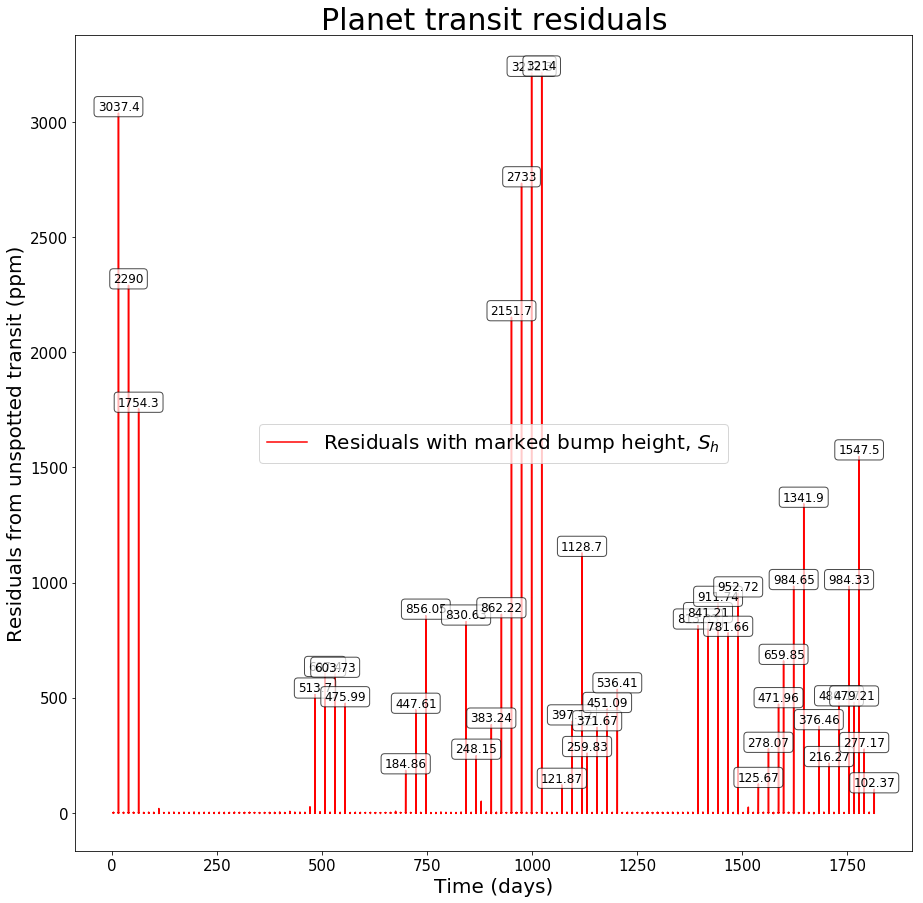

In [11]:
residuals = np.asarray(D_none) - np.asarray(D_noise)
peaks = peakdetect.peakdetect(residuals, Time, 1, noiseLevel)[0]

plt.figure(figsize=(15,15))
plt.plot(Time, residuals/ppm, 'r', label=r'Residuals with marked bump height, $S_h$')

widths = []
if len(peaks) >= 1:
    t_max, d_max = zip(*peaks)
    
    for (t, d) in zip(t_max, d_max):
        plt.text(t, d/ppm,'{0:.5g}'.format(d/ppm), fontsize=12, verticalalignment='bottom', horizontalalignment='center', bbox=dict(boxstyle='round', facecolor='w', alpha=0.7))
        
        # Find widths of peaks
        # Go right
        counter = 100
        idx = np.argwhere(Time == t)[0][0]
        while(counter > noiseLevel):
            idx += 1
            counter = residuals[idx]
        t_high = Time[idx]
        
        # Go left
        counter = 100
        idx = np.argwhere(Time == t)[0][0]
        while(counter > noiseLevel):
            idx -= 1
            counter = residuals[idx]
        t_low = Time[idx]
        widths.append(t_high-t_low)
else:
    print('No spots detected')

errorInTime = np.mean(np.asarray(widths)/2)
print('Error in time:',errorInTime)
plt.ylabel('Residuals from unspotted transit (ppm)', fontsize=20)
plt.xlabel('Time (days)', fontsize=20)
plt.title(r'Planet transit residuals', fontsize=30)
plt.legend(fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Generate and plot Butterfly diagram

In [12]:
# Get found spots, simulated spots and closest matched spots
fs, rs, ms = system.butterfly(residuals, noiseLevel, Time, errorInTime, TTimes)

Error in latitude due to time: 6.38382066446


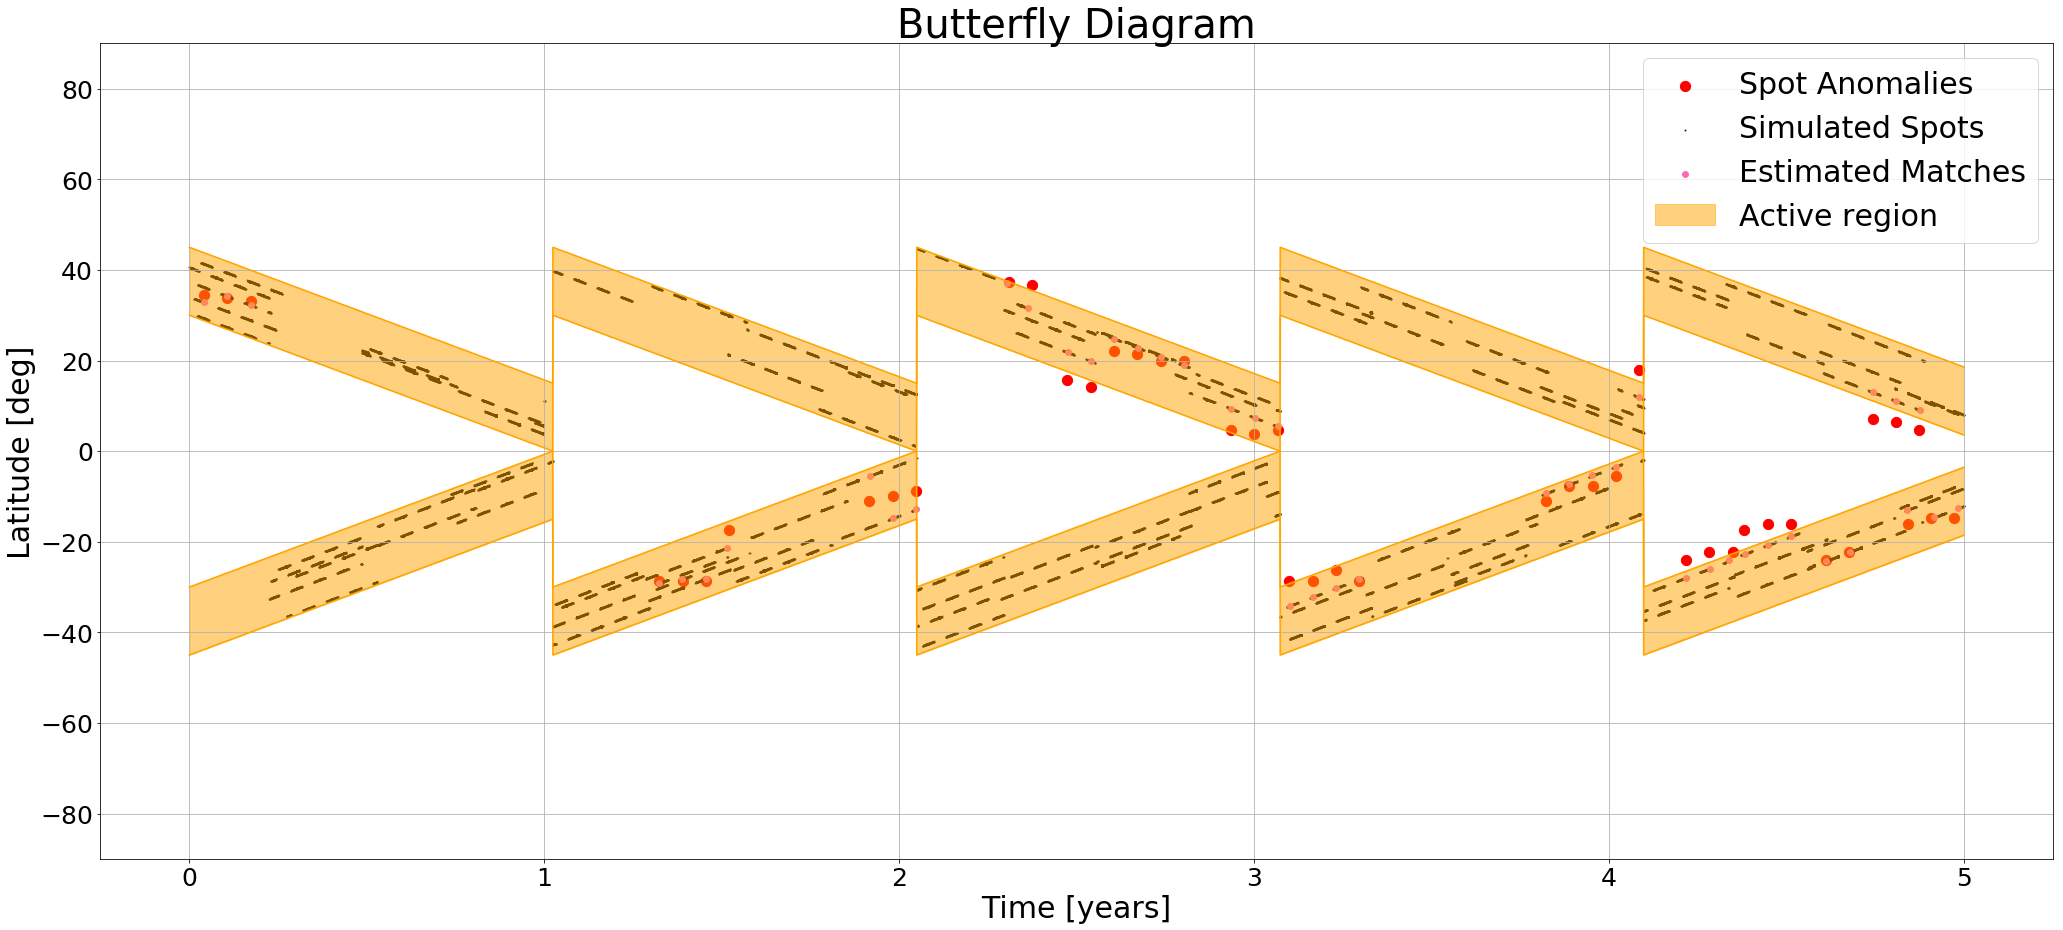

In [24]:
 OneDayInYears = 0.00273973
# Extract wanted variables
fs_lats = [s.coords[1] for s in fs]
fs_times = [s.timeFound*OneDayInYears for s in fs]
fs_lat_error = np.mean(np.asarray([s.latWidth for s in fs])/2)
rs_lats = [s.coords[1] for s in rs]
rs_times = [s.timeFound*OneDayInYears for s in rs]
ms_lats = [s.coords[1] for s in ms]
ms_times = [s.timeFound*OneDayInYears for s in ms]

# Calculated active bands
activeBandLines, activeTimes = zip(*SAR)
activeTimes = np.asarray(activeTimes)*OneDayInYears
lowBandLine, highBandLine = zip(*activeBandLines)

plt.figure(figsize=(35,15))

print('Error in latitude due to time:',fs_lat_error)

# Plot spots
#plt.errorbar(fs_times, fs_lats, xerr=errorInTime*OneDayInYears, yerr=fs_lat_error, c='r', marker='o', fmt='o', capsize=5, label='Spot Anomalies')
plt.scatter(fs_times, fs_lats, 105, c='r', marker='o', label='Spot Anomalies')
plt.scatter(rs_times, rs_lats, 5, c='k', marker='.', alpha=0.7, label='Simulated Spots')
plt.scatter(ms_times, ms_lats, 35, c='hotpink', marker='o', label='Estimated Matches')
# Plot active regions
plt.plot(activeTimes, lowBandLine, 'orange')
plt.plot(activeTimes, highBandLine, 'orange')
plt.plot(activeTimes, -1*np.asarray(lowBandLine), 'orange')
plt.plot(activeTimes, -1*np.asarray(highBandLine), 'orange')
plt.fill_between(activeTimes, lowBandLine, highBandLine, color='orange', alpha=0.5, label='Active region')
plt.fill_between(activeTimes, -1*np.asarray(lowBandLine), -1*np.asarray(highBandLine), color='orange', alpha=0.5)
# Plot params
plt.title(r'Butterfly Diagram', fontsize=40)
plt.xlabel('Time [years]', fontsize=30)
plt.ylabel('Latitude [deg]', fontsize=30)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.ylim([-90,90])
plt.grid()
plt.legend(fontsize=30)
plt.show()

### Spot map assuming constant average b=0.3

/Users/Jimbo/anaconda3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:598: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x18172d9728> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


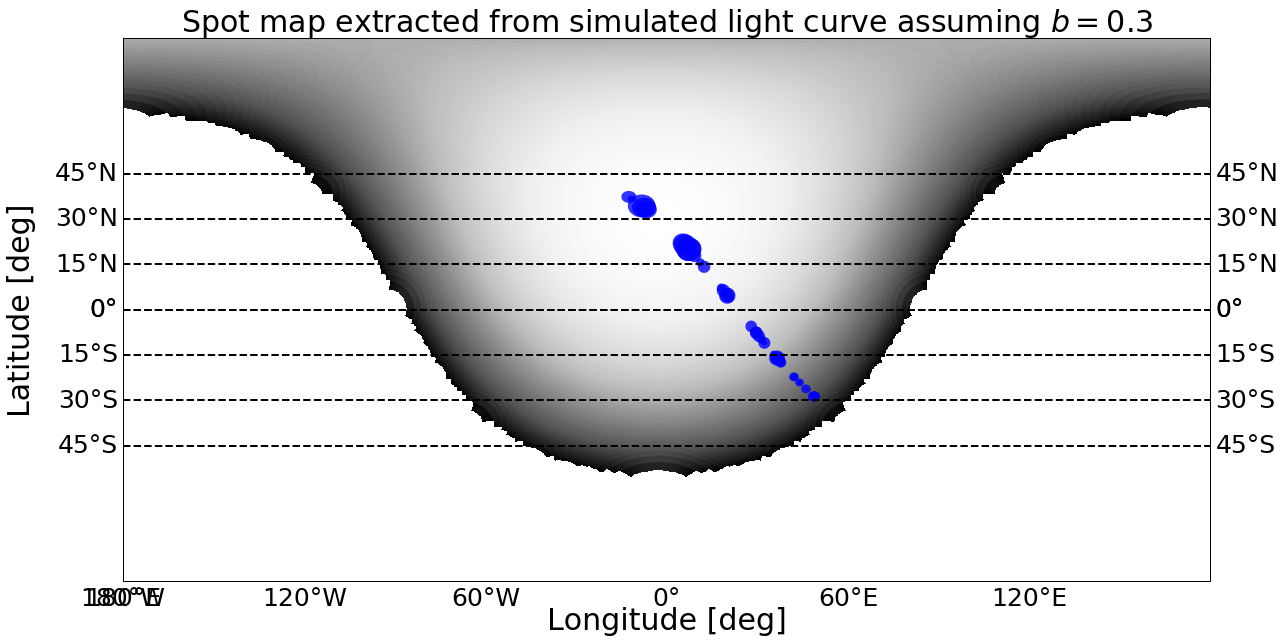

In [16]:
fs_longs = [s.coords[0] for s in fs]
fs_sh = [s.brightness for s in fs] # Anomaly heights

# Assume spots have b=0.3 and are all smaller than planet
b = 0.3
d_unspotted = params.rp**2
factor = (1-b)*d_unspotted
fs_rs = [np.sqrt(sh/factor)*params.rp for sh in fs_sh] # Found spot radii in R_* units

# Plate Carree projection
star_long = 360*((dur/params.prot)%1)
plate_proj = ccrs.PlateCarree(central_longitude = star_long, globe=star.globe)
plt.figure(figsize=(20,10))
ax = plt.axes(projection=plate_proj)
ax.set_global()

cmap = plt.cm.Greys_r
ax.imshow(star.unspottedFlux, cmap=cmap, transform=star.orth_proj, interpolation='bilinear')
#ax.contourf(star.grid_x, star.grid_y, star.unspottedFlux, 10, cmap=cmap, transform=star.orth_proj)

# Plot spots
utils.tissot(fs_rs,fs_longs,fs_lats,80,star.globe,ax=ax,draw=True,facecolor='b',alpha=0.8)

# Set grid lines
gl = ax.gridlines(crs=ccrs.PlateCarree(central_longitude=star_long), draw_labels=True,
                  linewidth=2, color='k', linestyle='--')
gl.xlabels_top = False
gl.xlines = False

gl.ylocator = mticker.FixedLocator([-params.high_band[1], -params.high_band[0], -params.low_band[1], -params.low_band[0], params.low_band[0], params.low_band[1], params.high_band[0], params.high_band[1]])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 25, 'color': 'k'}
gl.xlabel_style = {'size': 25, 'color': 'k'}

ax.set_title(r'Spot map extracted from simulated light curve assuming $b=0.3$', fontsize=30)
ax.text(-0.08, 0.50, 'Latitude [deg]', fontsize=30, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.1, 'Longitude [deg]', va='bottom', ha='center',
        rotation='horizontal', fontsize=30, rotation_mode='anchor',
        transform=ax.transAxes)
plt.show()